# Visualization

In [ ]:
import os
import json
import pickle

import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

from zpinn.pinn_nf2_visualization import pinn_cube, draw_grid
from zpinn.pinn_nf2_cleanup import create_coordinates

In [ ]:
with open('config.json') as config:
    info = json.load(config)

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = info['jax_prealo']
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= info['cuda_visible']

input_path = info['input_path']
input_original = os.path.join(input_path, 'original')

In [ ]:
b_path = os.path.join(input_original, "b.pickle")

with open(b_path,"rb") as f:
    b = pickle.load(f)

In [ ]:
bi = draw_grid(b.grid)

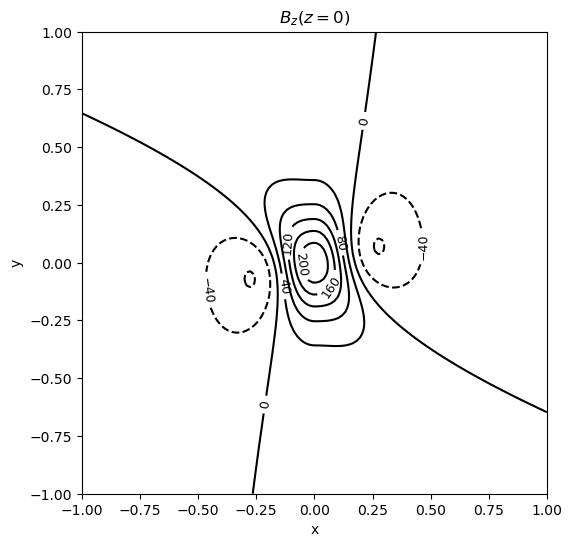

In [ ]:
bi.plt_Bz()

In [ ]:
pv.set_jupyter_backend('static')

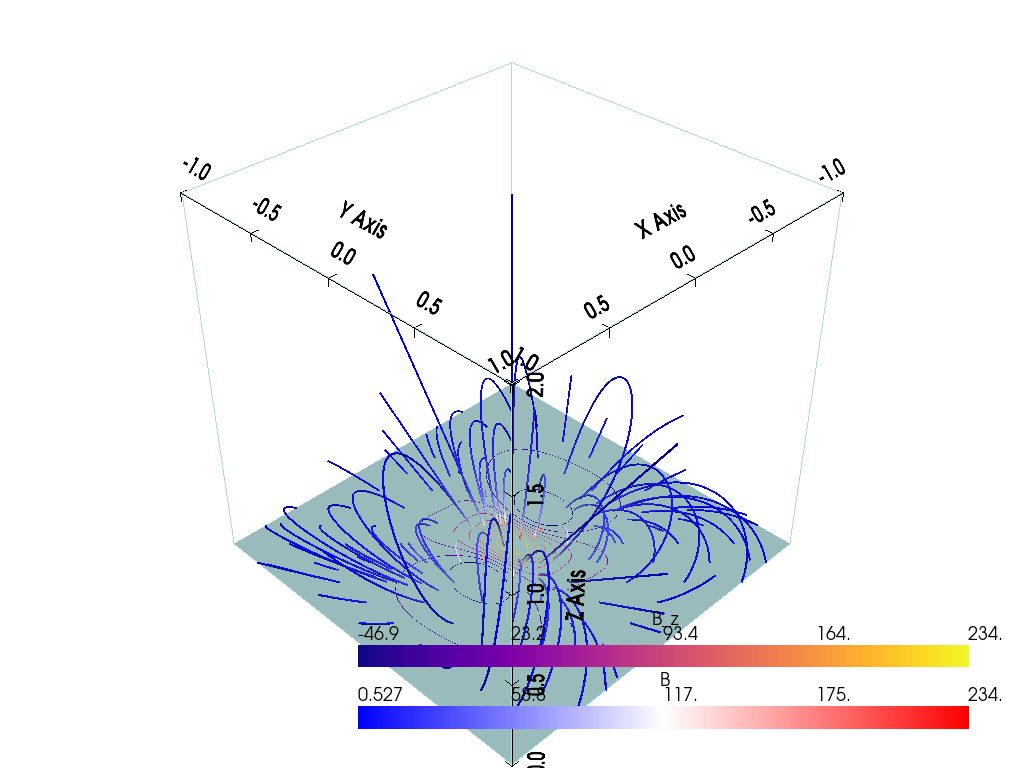

In [ ]:
bi.pv_streamline()

In [ ]:
bp_path = os.path.join(input_original, "bp.pickle")

with open(bp_path,"rb") as f:
    bp = pickle.load(f)

In [ ]:
bpi = draw_grid(bp.grid)

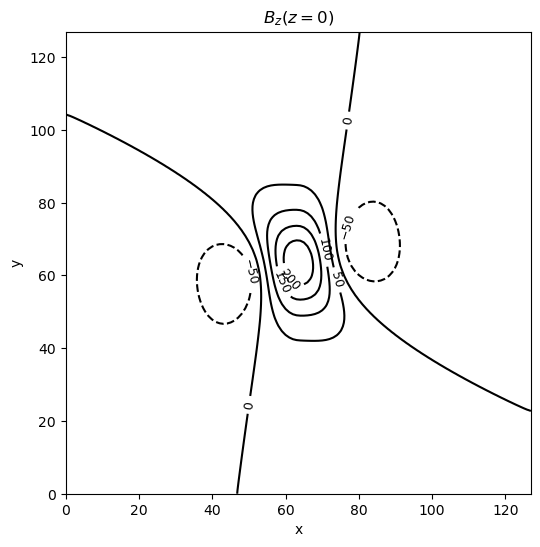

In [ ]:
bpi.plt_Bz()

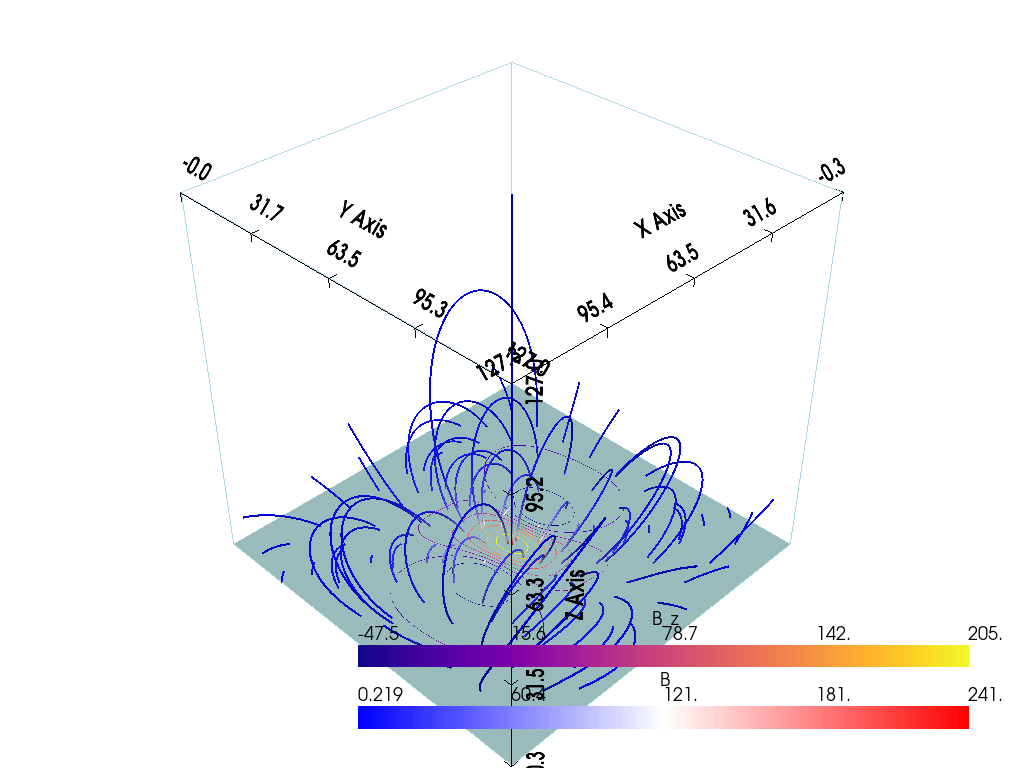

In [ ]:
bpi.pv_streamline()

In [ ]:
b_array = b.grid['B'].reshape(b.grid.dimensions[0], b.grid.dimensions[1], b.grid.dimensions[2], 3)
bp_array = bp.grid['B'].reshape(bp.grid.dimensions[0], bp.grid.dimensions[1], bp.grid.dimensions[2], 3)

In [ ]:
import pandas as pd

In [ ]:
from zpinn.pinn_nf2_metric import metric_df

In [ ]:
df_b = metric_df(B=b_array, b=b_array, B_potential=bp_array, iteration=-2)
df_bp = metric_df(B=bp_array, b=b_array, B_potential=bp_array, iteration=-1)
df = pd.concat([df_b, df_bp], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.514065,0.879512,2.134811,1.715319,1.000000
1,-1,0.893935,0.897016,0.456951,0.373536,0.660474,1.000000,0.938600,2.426637,1.840048,0.795598


## PINN

In [ ]:
pinn_iter = 2000
save_path = os.path.join(info['output_pinn'], 'model_%06d.pt' % pinn_iter)

In [ ]:
pinn = pinn_cube(save_path)

In [ ]:
pinn.state

{'iteration': 2000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0-7): 8 x Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 'cube_shape': (128, 128, 128),
 'b_norm': 100,
 'spatial_norm': 32,
 'loss_bc': array(0.00073718, dtype=float32),
 'w_bc': 575.5989592364506,
 'loss_div': array(0.04197716, dtype=float32),
 'w_div': 1,
 'loss_ff': array(0.05378867, dtype=float32),
 'w_ff': 1,
 'LR': 0.00031555132225266885}

In [ ]:
pinn.calculate_magnetic_fields(batch_size=10000)

  0%|          | 0/210 [00:00<?, ?it/s]

100%|██████████| 210/210 [00:01<00:00, 150.95it/s]


ImageData (0x7f56a18aa8c0)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
pi = draw_grid(pinn.grid)

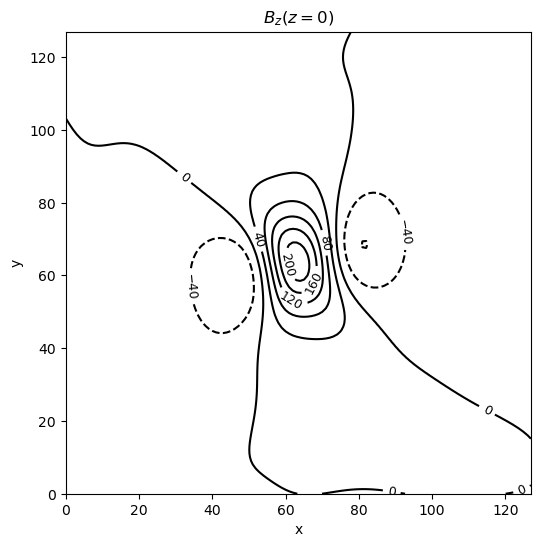

In [ ]:
pi.plt_Bz()

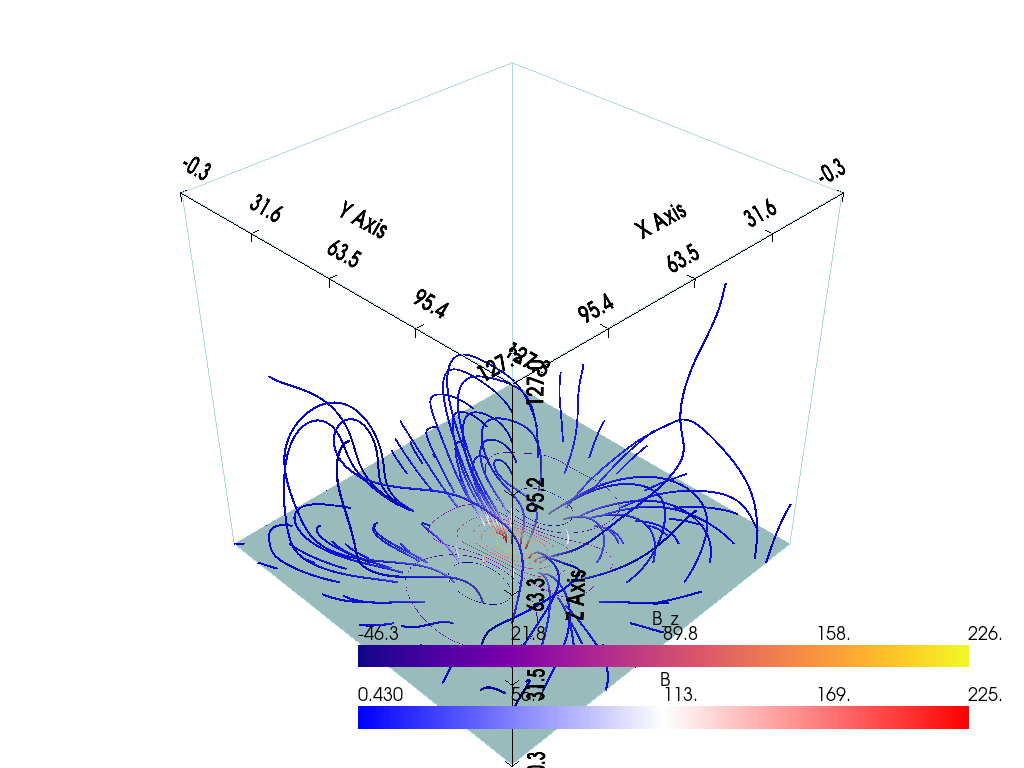

In [ ]:
pi.pv_streamline()

In [ ]:
Bpinn_array = pinn.grid['B'].reshape(pinn.grid.dimensions[0], pinn.grid.dimensions[1], pinn.grid.dimensions[2], 3)

In [ ]:
df_new = metric_df(B=Bpinn_array, b=b_array, B_potential=bp_array, iteration=f'pinn_{pinn_iter}')
df = pd.concat([df, df_new], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.514065,0.879512,2.134811,1.715319,1.000000
1,-1,0.893935,0.897016,0.456951,0.373536,0.660474,1.000000,0.938600,2.426637,1.840048,0.795598
2,pinn_2000,0.777910,0.487213,0.110105,-0.419099,1.212643,1.836021,0.876367,2.297016,1.981399,1.363403


## SPINN

In [ ]:
from zpinn.spinn_cleanup import load_spinn_mag

In [ ]:
nx = info['nx']
ny = info['ny']
nz = info['nz']
b_norm = info['b_norm']

In [ ]:
spinn_iter = 2000
result_path = info['output_spinn']
param_path = os.path.join(result_path, f"params_{spinn_iter}.pickle")

with open(param_path,"rb") as f:
    params = pickle.load(f)

B = load_spinn_mag(param_path, nx, ny, nz, b_norm)

In [ ]:
Bx = B[..., 0]
By = B[..., 1]
Bz = B[..., 2]

In [ ]:
with open('config.json') as config:
    info = json.load(config)

nx = info['nx']
ny = info['ny']
nz = info['nz']

In [ ]:
co_bounds = (0, nx-1, 0, ny-1, 0, nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(nx, ny, nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
ggrid = pv.StructuredGrid(x, y, z)
vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
ggrid['B'] = vectors
ggrid.active_vectors_name = 'B'
magnitude = np.linalg.norm(vectors, axis=-1)
ggrid['mag'] = magnitude
ggrid.active_scalars_name = 'mag'

ggrid

StructuredGrid (0x7f562c6f06a0)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  N Arrays:     2

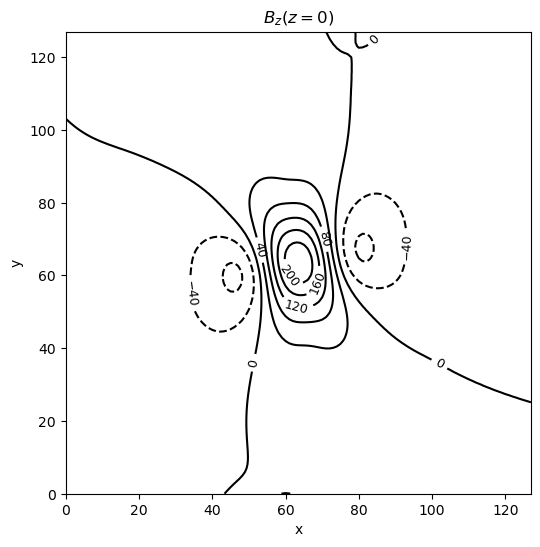

In [ ]:
aaa = draw_grid(ggrid)
aaa.plt_Bz()

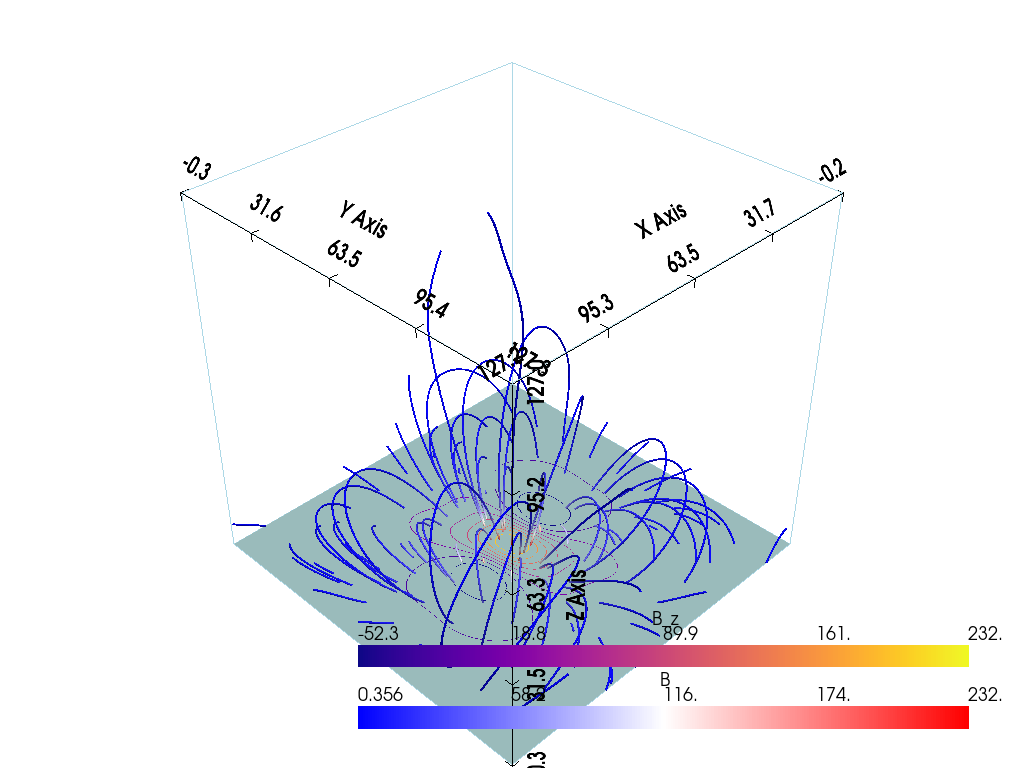

In [ ]:
aaa.pv_streamline()

In [ ]:
Bspinn_array = aaa.grid['B'].reshape(aaa.grid.dimensions[0], aaa.grid.dimensions[1], aaa.grid.dimensions[2], 3)

In [ ]:
df_new = metric_df(B=Bspinn_array, b=b_array, B_potential=bp_array, iteration=f'spinn_{spinn_iter}')
df = pd.concat([df, df_new], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.514065,0.879512,2.134811,1.715319,1.000000
1,-1,0.893935,0.897016,0.456951,0.373536,0.660474,1.000000,0.938600,2.426637,1.840048,0.795598
2,pinn_2000,0.777910,0.487213,0.110105,-0.419099,1.212643,1.836021,0.876367,2.297016,1.981399,1.363403
3,spinn_2000,0.989066,0.930066,0.719909,0.510715,0.859170,1.300839,0.902516,2.079571,1.532793,0.891536


# Multi

In [ ]:
df_b = metric_df(B=b_array, b=b_array, B_potential=bp_array, iteration=-2)
df_bp = metric_df(B=bp_array, b=b_array, B_potential=bp_array, iteration=-1)
df = pd.concat([df_b, df_bp], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.514065,0.879512,2.134811,1.715319,1.000000
1,-1,0.893935,0.897016,0.456951,0.373536,0.660474,1.000000,0.938600,2.426637,1.840048,0.795598


In [ ]:
iters = np.arange(1000, 10001, 1000)

for iter in iters:
    save_path = os.path.join(info['output_pinn'], 'model_%06d.pt' % iter)
    pinn = pinn_cube(save_path)
    pinn.calculate_magnetic_fields(batch_size=10000)
    Bpinn_array = pinn.grid['B'].reshape(pinn.grid.dimensions[0], pinn.grid.dimensions[1], pinn.grid.dimensions[2], 3)
    df_new = metric_df(B=Bpinn_array, b=b_array, B_potential=bp_array, iteration=f'pinn_{iter}')
    df = pd.concat([df, df_new], ignore_index=True)

    param_path = os.path.join(result_path, f"params_{iter}.pickle")
    with open(param_path,"rb") as f:
        params = pickle.load(f)
    B = load_spinn_mag(param_path, nx, ny, nz, b_norm)
    Bx = B[..., 0]
    By = B[..., 1]
    Bz = B[..., 2]
    co_bounds = (0, nx-1, 0, ny-1, 0, nz-1)
    co_coords = create_coordinates(co_bounds).reshape(-1, 3)
    co_coord = co_coords.reshape(nx, ny, nz, 3)
    x = co_coord[..., 0]
    y = co_coord[..., 1]
    z = co_coord[..., 2]
    ggrid = pv.StructuredGrid(x, y, z)
    vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    ggrid['B'] = vectors
    ggrid.active_vectors_name = 'B'
    magnitude = np.linalg.norm(vectors, axis=-1)
    ggrid['mag'] = magnitude
    ggrid.active_scalars_name = 'mag'
    aaa = draw_grid(ggrid)
    Bspinn_array = aaa.grid['B'].reshape(aaa.grid.dimensions[0], aaa.grid.dimensions[1], aaa.grid.dimensions[2], 3)
    df_new = metric_df(B=Bspinn_array, b=b_array, B_potential=bp_array, iteration=f'spinn_{iter}')
    df = pd.concat([df, df_new], ignore_index=True)

df

100%|██████████| 210/210 [00:00<00:00, 220.68it/s]


,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.514065,0.879512,2.134811,1.715319,1.000000
1,-1,0.893935,0.897016,0.456951,0.373536,0.660474,1.000000,0.938600,2.426637,1.840048,0.795598
2,pinn_1000,0.663484,0.497078,-1.215090,-4.011792,3.482434,5.272631,0.851249,3.274638,3.004647,2.308815
3,spinn_1000,0.987475,0.911956,0.704154,0.492131,0.852547,1.290811,0.904983,2.058151,1.535988,0.885955
4,pinn_2000,0.777910,0.487213,0.110105,-0.419099,1.212643,1.836021,0.876367,2.297016,1.981399,1.363403
5,spinn_2000,0.989066,0.930066,0.719909,0.510715,0.859170,1.300839,0.902516,2.079571,1.532793,0.891536
6,pinn_3000,0.924226,0.630026,0.448096,-0.107327,1.069320,1.619020,0.879469,2.194868,1.905580,1.115397
7,spinn_3000,0.989230,0.935469,0.722012,0.515982,0.857634,1.298514,0.905724,2.064012,1.522949,0.886477
8,pinn_4000,0.968902,0.692076,0.608593,0.175189,0.933938,1.414042,0.882256,1.978399,1.773880,1.001700
9,spinn_4000,0.989812,0.937396,0.730202,0.533173,0.862641,1.306095,0.901987,2.077171,1.525826,0.892693
